In [3]:
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize  # You may need to install nltk and download punkt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from utilities import *
from sklearn.feature_selection import f_classif

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# pick full or smaller version of dataset
df = pd.read_csv('modelready_220423.csv')

## Cleaning and baseline models

In [6]:
# print non-numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print(f'tot columns = {len(df.columns)}, numeric type columns = {len(df.select_dtypes(include=numerics).columns)}' ) # not too many non-numeric columns
df.select_dtypes(include = ['object']).head(1)  

tot columns = 772, numeric type columns = 765


,publication_number,company_name,countries_in_family,publn_nr,primary_cpc,abstract,description_text
0,US-8623043-B1,"Entellus Medical, Inc.",['AU' 'EP' 'CA' 'US'],8623043,A61M29/02,A method of treating a constricted sinus passa...,RELATED APPLICATIONS \n This Application i...


In [7]:
# extract unique countries in the df
unique_values = set()
df['countries_in_family'].apply(lambda x: unique_values.update(x.strip("[]").replace("'", "").split())) 

# Create new columns for each unique value
for value in unique_values:
    # each country has a column (1 if the patent belong to the country 0 otherwise)
    df[value] = df['countries_in_family'].apply(lambda x: 1 if value in x else 0)


In [8]:
df = df[df.abstract.notna()].copy() # drop all samples without abstract
print('missing value in description text' , df.description_text.isna().sum()) # description_text doesn't have mssing vales

missing value in description text 0


In [9]:
# encode company names
df['company_name_encoded'] = df.company_name.astype('category').cat.codes  # encode companies

# remove non-numeric columns
df_columns_dropped = df.drop(['publication_number', 'company_name', 'countries_in_family', 'publn_nr','primary_cpc'], axis = 1)

# f0_ has the same value as commercialization, the other two shouldn't be used
df_columns_dropped = df_columns_dropped.drop(['f0_', 'centrality', 'similarity'], axis = 1)

In [10]:
# remove text as I can't compute min and max on it
text = df_columns_dropped[['abstract', 'description_text']] # putting them aside for later
df_columns_dropped.drop(['abstract', 'description_text'], axis=1, inplace=True)

In [11]:
# extracting what we'll try to predict
y = df_columns_dropped['commercialized']
df_columns_dropped.drop('commercialized', axis= 1, inplace=True)

In [12]:
# dropping columns where all the value are the same (only one unique value) they would be zero if I apply min max rescaling
nunique = df_columns_dropped.nunique()
cols_to_drop = nunique[nunique == 1].index
df_clean = df_columns_dropped.drop(cols_to_drop, axis=1)

In [13]:
# splitting train and test and trying best preprocessing on training set
# all preprocessing will be done on X_train and only in the end tested on X_test
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20)

### Select best way to fill missing values

In [11]:
# TODO: rerun
# find best method for filling missing values

accuracies = []

#rescale 
scaler = ('scaler', StandardScaler())
filling_methods = ['mean', 'median', 'most_frequent', 'zero']

for method in filling_methods:
    # Make a copy of the original data to avoid modifying it
    data_filled = X_train.copy()

    # Fill NaN values based on the selected method
    if method == 'zero':
        # data_filled = data_filled.fillna(0)  # You can choose any constant value
        imputer =  ('imputer', SimpleImputer(strategy='constant', fill_value=0))
    else:
        imputer = ('imputer', SimpleImputer(strategy=method, keep_empty_features=False))
    
    # default max_iter was reached, so increased it
    model = ('model', LogisticRegression(max_iter=1000))

    #rescale 
    # scaler.fit(data_filled)
    # data_filled = scaler.transform(data_filled)

    pipeline = Pipeline([imputer ,scaler, model])

    # Perform cross-validation and print the mean score
    scores_dict = cross_validate(estimator=pipeline, X=data_filled, y=y_train, n_jobs=5, cv=5,scoring=['f1', 'accuracy', 'precision', 'recall'])

    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'method:{method}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 

method:mean
Average F1 Score: 0.8768672758214603
Average Accuracy: 0.8929402945172583
Average Precision: 0.889420960318955
Average Recall: 0.8646747752511897

method:median
Average F1 Score: 0.8771966777629532
Average Accuracy: 0.8932200637086265
Average Precision: 0.8897090898813357
Average Recall: 0.8650449497620306

method:most_frequent
Average F1 Score: 0.8772071483561273
Average Accuracy: 0.8932433791667751
Average Precision: 0.8898397829546603
Average Recall: 0.8649391856160762

method:zero
Average F1 Score: 0.8770293133331581
Average Accuracy: 0.8930801763952063
Average Precision: 0.889586183000352
Average Recall: 0.8648334214701217



In [96]:
# perform ANOVA test to see if there is significant difference between the accuracies

f_statistic, p_value = f_oneway(*accuracies)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 0.1862935451418707
P-value: 0.9041639871526389
There is no significant difference in means between the accuracy vectors.


In [14]:
# create new train test split with missing values filled
df_clean.fillna(0, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20)

So, it doesn't matter which filling method we will use. 

### Vectorization of text (bag of words)

In [11]:
# putting text back in
df_clean[['abstract', 'description_text']] = text  

# split again
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20, random_state=42)

X_no_text = X_train.drop(['abstract', 'description_text'],  axis = 1)

In [15]:
# Example: Assuming 'X_train' contains your abstracts
# Tokenize the text
tokenized_text = [word_tokenize(text) for text in X_train['abstract']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=300, window=5, min_count=1, workers=8)

# Encode abstracts using the trained Word2Vec model
encoded_abstracts = []
for words in tokenized_text:
    # Take the mean of word vectors for each abstract
    encoded_abstract = np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0)
    encoded_abstracts.append(encoded_abstract)

# 'encoded_abstracts' now contains the encoded versions of your abstracts
# encoded_abstracts

In [18]:
# Create pipeline, will use teh best model found before
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
    ('scaler', StandardScaler(with_mean=False)), 
    ('random_forest', LogisticRegression(random_state=42, max_iter=10000))
    ])

# Define vectorizers
vectorizers = {
    'Count Vectorizer': CountVectorizer(max_features = 300),
    'Word2Vec' : None,
    'TF-IDF Vectorizer': TfidfVectorizer(max_features = 300),
}

X_train_only_text = X_train[['abstract']]
# Tokenize text for Word2Vec
tokenized_text = [word_tokenize(text) for text in X_train['abstract']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
accuracies = []
# Transform text data using different vectorization methods and evaluate models

for vectorizer_name, vectorizer in vectorizers.items():
    if 'Word2Vec' in vectorizer_name:
        # Use Word Embeddings (Word2Vec) for Word Embeddings model
        X_train_transformed = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_text])
        X_train_transformed = pd.DataFrame(X_train_transformed).reset_index(drop=True)
    else:
        # Use Count Vectorization or TF-IDF Vectorization for other models
        X_train_transformed = vectorizer.fit_transform(X_train_only_text['abstract'].values)
        X_train_transformed = pd.DataFrame(X_train_transformed.toarray()).reset_index(drop=True)

    
    X_train_transformed = pd.concat([X_no_text.reset_index(drop=True), X_train_transformed], axis=1)
    X_train_transformed.columns = X_train_transformed.columns.astype(str) 

    # print(X_train_transformed.head(1))
    # print(X_train_transformed.select_dtypes(include = ['object']).head(1)  )

    # Evaluate the model using cross-validation
    scores_dict = cross_validate(pipeline, X_train_transformed, y_train, cv=2, n_jobs=5, scoring=['f1', 'accuracy', 'precision', 'recall'])

    # Print the mean accuracy for each combination
    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'model:{vectorizer_name}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 


model:Count Vectorizer
Average F1 Score: 0.8740139802811113
Average Accuracy: 0.8907255432248438
Average Precision: 0.8869105119031999
Average Recall: 0.8614879186095803

model:Word2Vec
Average F1 Score: 0.874449725268549
Average Accuracy: 0.8911218875314744
Average Precision: 0.8875273807949027
Average Recall: 0.8617528613819415

model:TF-IDF Vectorizer
Average F1 Score: 0.8734154393901576
Average Accuracy: 0.890142683950387
Average Precision: 0.8857900498071526
Average Recall: 0.8613819415006359



In this section we have considered a dataset made of the features and the words embedings (created with different techniques). CountVectorizer is the one that leads to the best results, but these (even if close) don't improve the baseline model. Thus in the following section we won't consider the word embeddings. <br>
Due to computational limitation we could only compute the word embeding on the abstract (as it was shorter) and not on description_text (text description of images). In any case the abstract is probably the one with more relevant information. 

### Model selection

In [21]:
# model selection

accuracies = []

pipe_step = [('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Fill missing values with zero
    ('scaler', MinMaxScaler())]

models = {
    'Naive Bayes': MultinomialNB(), 
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000),
    'Gradient Boosted Trees': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42)
}

# Perform model selection using cross-validation
for model_name, model in models.items():
    

    pipeline = Pipeline(pipe_step + [(model_name, model)])
    # Print the cross-validation scores
    scores_dict = cross_validate(estimator=pipeline, X=X_train, y=y_train, cv=5, n_jobs=5, scoring=['f1', 'accuracy', 'precision', 'recall'])

    accuracies.append(scores_dict["test_accuracy"])

    # Print the results
    print(f'model:{model_name}')
    print(f'Average F1 Score: {np.mean(scores_dict["test_f1"])}')
    print(f'Average Accuracy: {np.mean(scores_dict["test_accuracy"])}')
    print(f'Average Precision: {np.mean(scores_dict["test_precision"])}')
    print(f'Average Recall: {np.mean(scores_dict["test_recall"])}')
    print() 


model:Naive Bayes
Average F1 Score: 0.7981264063990366
Average Accuracy: 0.8180546629679728
Average Precision: 0.7815569820983869
Average Recall: 0.8154240289399723

model:Random Forest
Average F1 Score: 0.9105827845413541
Average Accuracy: 0.9216637322816854
Average Precision: 0.9168938455832066
Average Recall: 0.9043818065575439

model:Logistic Regression
Average F1 Score: 0.8778932106640829
Average Accuracy: 0.8940828606759916
Average Precision: 0.8930735372629087
Average Recall: 0.8632590776920672

model:Neural Network
Average F1 Score: 0.8954278596607255
Average Accuracy: 0.907348731283325
Average Precision: 0.8915868277870558
Average Recall: 0.8996246421204466

model:Gradient Boosted Trees
Average F1 Score: 0.8850025699691113
Average Accuracy: 0.9006107432489193
Average Precision: 0.9037215831408009
Average Recall: 0.8670646304067546

model:SVM
Average F1 Score: 0.8815568422902347
Average Accuracy: 0.8982094576075428
Average Precision: 0.9055136363114755
Average Recall: 0.8588717

In [24]:
# perform ANOVA test to see if there is significant difference between the accuracies
f_statistic, p_value = f_oneway(*accuracies)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 732.1790424391622
P-value: 2.0941088839896943e-25
The means of the accuracy vectors are significantly different.


In [28]:
list(models.keys())[0]

'Naive Bayes'

In [31]:
from scipy.stats import ttest_rel

# Perform paired t-test for each pair of lists
num_lists = len(accuracies)
model_names = list(models.keys())

for i in range(num_lists - 1):
    for j in range(i + 1, num_lists):
        acc_list_1 = accuracies[i]
        acc_list_2 = accuracies[j]

        # Perform paired t-test
        t_statistic, p_value = ttest_rel(acc_list_1, acc_list_2)

        # Display the results
        # print(f"T-statistic for Pair {i+1}-{j+1}: {t_statistic}")
        # print(f"P-value for Pair {i+1}-{j+1}: {p_value}")

        # Check for statistical significance (common significance level is 0.05)
        if p_value < 0.05:
            print(f"The difference in accuracies between {model_names[i+1]} and {model_names[j-1]} is statistically significant.")
        else:
            print(f"There is no statistically significant difference in accuracies between Pair {model_names[i+1]} and {model_names[j-1]}.")

The difference in accuracies between Random Forest and Naive Bayes is statistically significant.
The difference in accuracies between Random Forest and Random Forest is statistically significant.
The difference in accuracies between Random Forest and Logistic Regression is statistically significant.
The difference in accuracies between Random Forest and Neural Network is statistically significant.
The difference in accuracies between Random Forest and Gradient Boosted Trees is statistically significant.
The difference in accuracies between Logistic Regression and Random Forest is statistically significant.
The difference in accuracies between Logistic Regression and Logistic Regression is statistically significant.
The difference in accuracies between Logistic Regression and Neural Network is statistically significant.
The difference in accuracies between Logistic Regression and Gradient Boosted Trees is statistically significant.
The difference in accuracies between Neural Network and

We performed cross validation on the different models in order to determine which one was the best fit for our data. We found that the difference in accuracies are statistically significant, thus we can conclude that Random forest is the best model among the considered ones. 

HYPERPARAMETER TUNING

In [15]:
from sklearn.model_selection import GridSearchCV

rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1) # grid search with 5-fold cross-val
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_rf_classifier = grid_search.best_estimator_
best_rf_classifier.fit(X_train, y_train)
y_pred = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Set Accuracy: 0.9273591943304738


In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Test Set Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Test Set Accuracy: 0.9273591943304738
Precision: 0.9273073838643956
Recall: 0.9273591943304738
F1-Score: 0.927319491126453


## Searching for most relevant features

In [16]:
accuracies_features = []  # store here the accuracies of different subset of features

In [17]:
# base line with all features
accuracies_features.append(train_RF(X_train, y_train))

Average F1 Score: 0.9121783280856958
Average Accuracy: 0.923155908014525
Average Precision: 0.9190403357096258
Average Recall: 0.9054218460724677


In [18]:
# case 1 - no google embeddings
google_embeddings = ['v1_0', 'v1_1', 'v1_2', 'v1_3', 'v1_4', 'v1_5', 'v1_6', 'v1_7', 'v1_8', 'v1_9', 'v1_10', 'v1_11', 'v1_12', 'v1_13', 'v1_14', 'v1_15', 'v1_16', 'v1_17', 'v1_18', 'v1_19', 'v1_20', 'v1_21', 'v1_22', 'v1_23', 'v1_24', 'v1_25', 'v1_26', 'v1_27', 'v1_28', 'v1_29', 'v1_30', 'v1_31', 'v1_32', 'v1_33', 'v1_34', 'v1_35', 'v1_36', 'v1_37', 'v1_38', 'v1_39', 'v1_40', 'v1_41', 'v1_42', 'v1_43', 'v1_44', 'v1_45', 'v1_46', 'v1_47', 'v1_48', 'v1_49', 'v1_50', 'v1_51', 'v1_52', 'v1_53', 'v1_54', 'v1_55', 'v1_56', 'v1_57', 'v1_58', 'v1_59', 'v1_60', 'v1_61', 'v1_62', 'v1_63']
df_no_google = modify_df(X_train, google_embeddings)
print("Case 1: No google embeddings")
accuracies_features.append(train_RF(df_no_google, y_train))
print()

# case 2 - no future info
future_info = ['forward_citations','litigated', 'renewed_after_first_term', 'renewed_after_second_term', 'renewed_after_third_term', 'opposed', 'fwd_cites_same_company']
df_no_future = modify_df(X_train, future_info)
print("Case 2: No future information")
accuracies_features.append(train_RF(df_no_future, y_train))
print()

# case 3 - no vpm_patent_score
vpm_patent_score = ['vpm_patent_score']
df_no_vpm = modify_df(X_train, vpm_patent_score)
print("Case 3: No vpm_patent_score")                                                                                                                                                                                
accuracies_features.append(train_RF(df_no_vpm, y_train))
print()

# case 4 - no future info
future_info_vpm = ['vpm_patent_score', 'forward_citations','litigated', 'renewed_after_first_term', 'renewed_after_second_term', 'renewed_after_third_term', 'opposed', 'fwd_cites_same_company']
df_no_future_vpm = modify_df(X_train, future_info_vpm)
print("Case 4: No future information and vpm")
accuracies_features.append(train_RF(df_no_future_vpm, y_train))
print()

# case 4 - no primary cpc as we are not supposed to normalized ------ ALREADY NOT THERE, MAYBE ENCODED IN DUMMY? CHECK
# primary_cpc = ['primary_cpc']
# df_no_cpc = modify_df(df_clean, primary_cpc)
# print("Case 4: No primary_cpc")
# train_RF(df_no_cpc, y)

Case 1: No google embeddings
Average F1 Score: 0.9054968930639621
Average Accuracy: 0.9179567782662424
Average Precision: 0.9196503741789893
Average Recall: 0.8917746627876223

Case 2: No future information
Average F1 Score: 0.9124705025870222
Average Accuracy: 0.9233657281137109
Average Precision: 0.9187114655793703
Average Recall: 0.9063210790796086

Case 3: No vpm_patent_score
Average F1 Score: 0.8750202271100745
Average Accuracy: 0.8913318350091755
Average Precision: 0.8871547858452864
Average Recall: 0.8632636868553293

Case 4: No future information and vpm
Average F1 Score: 0.8754026081482389
Average Accuracy: 0.8916582052217441
Average Precision: 0.8875801949114749
Average Recall: 0.8636339592700344



In [19]:
# CASE 5 - CPA, taking no future info as baseline as it achieved max accuracy
data = df_no_future.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA()
pca.fit(scaled_data)

PCA()

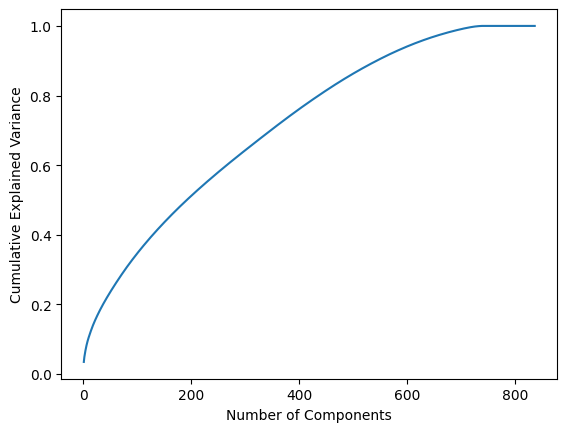

In [20]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [21]:
desired_variance = 0.95
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= desired_variance) + 1
print("Number of components selected:", n_components)

Number of components selected: 615


In [22]:
pca = PCA(n_components=627)
principal_components = pca.fit_transform(scaled_data)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components)

accuracies_features.append(train_RF(pc_df, y_train))

Average F1 Score: 0.8576575455069466
Average Accuracy: 0.8784854578424637
Average Precision: 0.8864823504993471
Average Recall: 0.8306797143612801


Explained Variance Ratio:
[0.03460264 0.01407924]


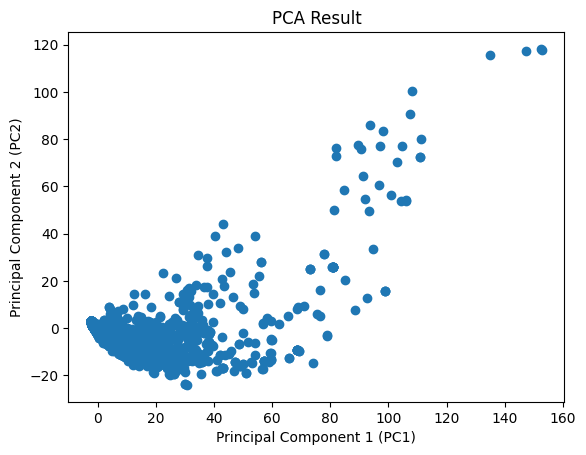

In [23]:
# CASE 5 - PCA, taking no future info as baseline as it achieved max accuracy
data = df_no_future.copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Display the explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Plot the results
plt.scatter(pc_df['PC1'], pc_df['PC2'])
plt.title('PCA Result')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.show()

In [24]:
# CASE 6 - using chi-square for feature selection
data = df_no_future.copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_train)

k_best = SelectKBest(score_func=chi2, k='all')
k_best.fit(scaled_data, y_train)

selected_features_indices = k_best.get_support(indices=True)

x_train_selected = k_best.transform(scaled_data)

accuracies_features.append(train_RF(x_train_selected, y_train))


Average F1 Score: 0.9117484901740941
Average Accuracy: 0.9227828634018811
Average Precision: 0.9186598021032711
Average Recall: 0.9049457815392753


In [25]:
# chi-square didn't drop any parameter, confirming they're are all usefull for reaching the optimal performances
len(selected_features_indices), len(X_train.columns)

(844, 844)

In [26]:
# perform ANOVA test to see if there is significant difference between the accuracies
f_statistic, p_value = f_oneway(*accuracies_features)

# Print the results
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value}')

# Check if the p-value is below the significance level (e.g., 0.05)
if p_value < 0.05:
    print('The means of the accuracy vectors are significantly different.')
else:
    print('There is no significant difference in means between the accuracy vectors.')

F-statistic: 99.13264998495931
P-value: 1.5181793202533522e-17
The means of the accuracy vectors are significantly different.


In [30]:
from scipy.stats import ttest_rel

feature_selection_type = ['baseline', 'no google embeddings', 'no future information', 'No vpm_patent_score', 'no future info and vppm', 'PCA: 618 features', 'chi-square feature selection']


print('Statistical test for difference between baseline accuracies and reduced features accuracies')
print()

# Perform paired t-test for each pair of lists
num_lists = len(accuracies_features)

for i in range(num_lists - 1):
    for j in range(i + 1, num_lists):
        acc_list_1 = accuracies_features[i]
        acc_list_2 = accuracies_features[j]

        # Perform paired t-test
        t_statistic, p_value = ttest_rel(acc_list_1, acc_list_2)

        # Display the results
        # print(f"T-statistic for Pair {i+1}-{j+1}: {t_statistic}")
        print(f"P-value for {feature_selection_type[i]} and {feature_selection_type[j]}: {p_value}")

        # Check for statistical significance (common significance level is 0.05)
        if p_value < 0.05:
            print(f"The difference in accuracies between {feature_selection_type[i]} and {feature_selection_type[j]} is statistically significant.")
        else:
            print(f"There is no statistically significant difference in accuracies between Pair {feature_selection_type[i]} and {feature_selection_type[j]}.")

        print()
    break

Statistical test for difference between baseline accuracies and reduced features accuracies

P-value for baseline and no google embeddings: 0.0006628338922366351
The difference in accuracies between baseline and no google embeddings is statistically significant.

P-value for baseline and no future information: 0.5796225360336489
There is no statistically significant difference in accuracies between Pair baseline and no future information.

P-value for baseline and No vpm_patent_score: 4.135928272235385e-06
The difference in accuracies between baseline and No vpm_patent_score is statistically significant.

P-value for baseline and no future info and vppm: 1.0286557146591188e-05
The difference in accuracies between baseline and no future info and vppm is statistically significant.

P-value for baseline and PCA: 618 features: 3.1423207689180155e-06
The difference in accuracies between baseline and PCA: 618 features is statistically significant.

P-value for baseline and chi-square feature

In [31]:
for name, accuracy in zip(feature_selection_type, accuracies_features): 
    print(name, np.mean(accuracy))

baseline 0.923155908014525
no google embeddings 0.9179567782662424
no future information 0.9233657281137109
No vpm_patent_score 0.8913318350091755
no future info and vppm 0.8916582052217441
PCA: 618 features 0.8784854578424637
chi-square feature selection 0.9227828634018811


In the following analysis we won't consider "chi-square feature selection" as that didn't drop any feature. <br>
Some differences between accuraccies are statistically, but not all of them. The interesting thing to notice is that the regularization that comes from dropping a certain subset of features doesn't lead to an improvement in performances.<br>
Removing google embedings and future information didn't lead to any statistical significant reduction in the accuracy which means that these information aren't of central importance for predicting commercialization

0.9258672137262216


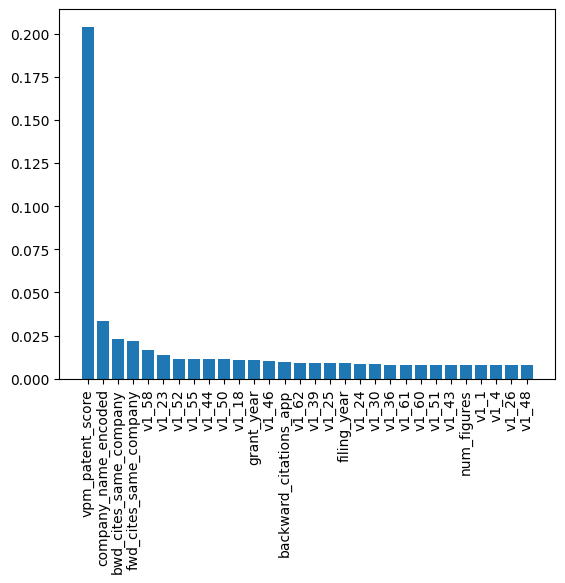

In [144]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(scaled_data, y_train)

y_pred = rf_classifier.predict(scaler.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

sorted_data = sorted(zip(X_train.columns, rf_classifier.feature_importances_), key=lambda x: x[1], reverse = True)

# Unzip the sorted data
names, feature_importances = zip(*sorted_data)

# Print the sorted lists

plt.bar(names[:30], feature_importances[:30])
plt.xticks(rotation = 90)
plt.show()

0.8956546064901156


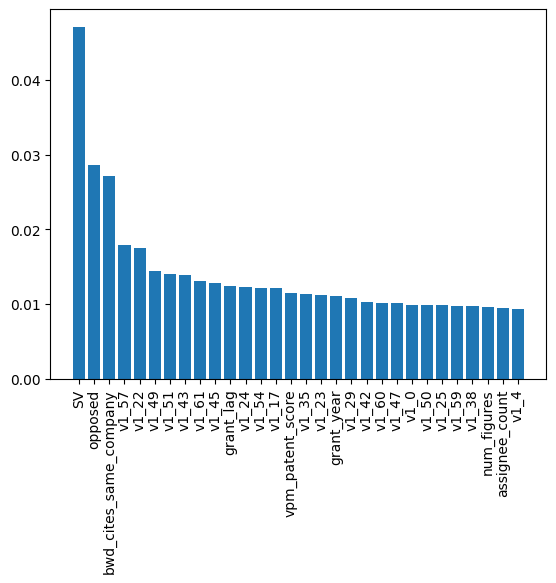

In [143]:
# SV (dummy variable for country el salvador) gets a lot of importance when when vpm_patent_score aren't present

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_vpm)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(scaled_data, y_train)

x_test_mod = modify_df(X_test, vpm_patent_score)
y_pred = rf_classifier.predict(scaler.transform(x_test_mod))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

sorted_data = sorted(zip(X_train.columns, rf_classifier.feature_importances_), key=lambda x: x[1], reverse = True)

# Unzip the sorted data
names, feature_importances = zip(*sorted_data)

# Print the sorted lists

plt.bar(names[:30], feature_importances[:30])
plt.xticks(rotation = 90)
plt.show()

0.9160760910108169


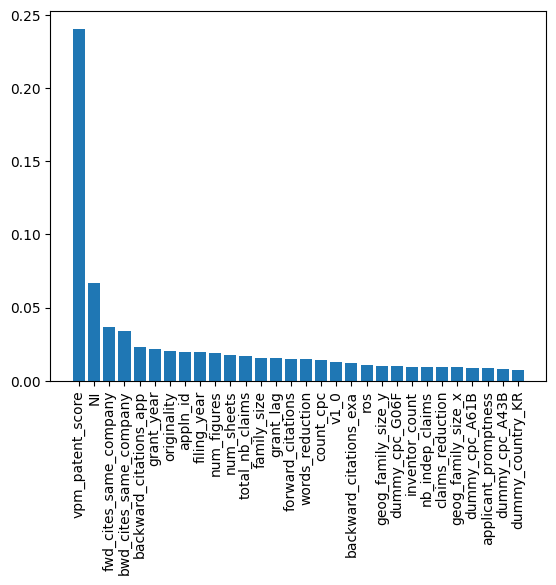

In [146]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_google)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(scaled_data, y_train)

x_test_mod = modify_df(X_test, google_embeddings)
y_pred = rf_classifier.predict(scaler.transform(x_test_mod))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

sorted_data = sorted(zip(X_train.columns, rf_classifier.feature_importances_), key=lambda x: x[1], reverse = True)

# Unzip the sorted data
names, feature_importances = zip(*sorted_data)

# Print the sorted lists

plt.bar(names[:30], feature_importances[:30])
plt.xticks(rotation = 90)
plt.show()

0.8940693770980978


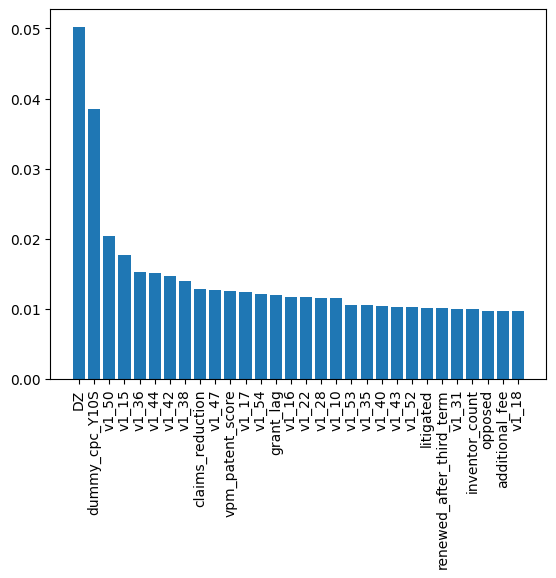

In [32]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_future_vpm)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(scaled_data, y_train)

x_test_mod = modify_df(X_test, future_info_vpm)
y_pred = rf_classifier.predict(scaler.transform(x_test_mod))
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

sorted_data = sorted(zip(X_train.columns, rf_classifier.feature_importances_), key=lambda x: x[1], reverse = True)

# Unzip the sorted data
names, feature_importances = zip(*sorted_data)

# Print the sorted lists

plt.bar(names[:30], feature_importances[:30])
plt.xticks(rotation = 90)
plt.show()

## Trying Bert to make prediction on the abstract and text description

In [11]:

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, features, texts, labels, tokenizer, max_length):
        self.features = features
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        text = list(self.texts.iloc[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        return {
            'features': torch.tensor(self.features.iloc[idx]),
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


from transformers import BertModel

class CustomBERTClassifier(torch.nn.Module):
    def __init__(self, num_classes, feature_dim):
        super(CustomBERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', num_labels=num_classes)
        
        # Freeze all BERT layers except the last three
        for param in self.bert.parameters():
            param.requires_grad = False
        for param in self.bert.encoder.layer[-3:].parameters():
            param.requires_grad = True

        self.fc = torch.nn.Linear(feature_dim + self.bert.config.hidden_size, 128)  # Adjust as needed
        self.final_layer = torch.nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, features):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        # Concatenate BERT output with additional features
        combined_features = torch.cat([pooled_output, features], dim=1)

        # Fully connected layer
        combined_features = torch.relu(self.fc(combined_features))

        # Final classification layer
        logits = self.final_layer(combined_features)

        return logits

In [12]:
df_clean[['abstract', 'description_text']] = text  # incorporate text
X_train, X_test, y_train, y_test = train_test_split(df_clean, y, test_size=0.20, random_state=42)

In [13]:
# load model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = 'cpu'

# Set up your data and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128  # Adjust as needed
num_classes = 2  # Binary classification

# reset indexes, otherwise it doesn't work
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

features = X_train.drop(['abstract', 'description_text'], axis = 1)
texts = X_train[['abstract', 'description_text']]

dataset = CustomDataset(features, texts, y_train, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = CustomBERTClassifier(num_classes, len(features.columns))
model.to(device)  # Move the model to GPU if available

print('loaded')

loaded


In [15]:

# Set up your optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    print('epoch:', epoch)
    model.train()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        features = features.to(torch.float32)       
        outputs = model(input_ids, attention_mask=attention_mask, features=features)
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        loss.backward()
        optimizer.step()    

        # explicity memory release otherwise fills all RAM
        del input_ids, attention_mask, features, labels, outputs, loss

/home/stefano/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


In [21]:
# prediction
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

features = X_test.drop(['abstract', 'description_text'], axis = 1)
texts = X_test[['abstract', 'description_text']]

dataset = CustomDataset(features, texts, y_test, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Make predictions for all elements in the dataset
all_predictions = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)

        features = features.to(torch.float32)   
        logits = model(input_ids, attention_mask=attention_mask, features=features)
        predicted_classes = torch.argmax(logits, dim=1).tolist()

        all_predictions.extend(predicted_classes)

In [22]:
(all_predictions == y_test).sum() / len(y_test)

0.5555762775083923